# Refactoring and Packaging Research Python Code
## With an example from agent-based financial modeling

This notebook is inspired by a [previous guide of mine](https://github.com/embray/notebooks/blob/master/simcluster.ipynb) of a similar nature, though designed originally for an astronomy audience (though the code is simple enough that most people with some background in scientific Python ([SciPy](https://www.scipy.org/scipylib/index.html), [NumPy](http://numpy.org/) should be able to follow it.  It was also based on Python 2.7, so a few of the details, especially concerning packaging, are a little bit outdated.  But the main points are still relevant, so it may make for an interesting companion to this guide.

### Introduction
The example code used from this tutorial is based on a simple implementation of an, simple two-type model by Gaunersdorfer and Hommes, taken from [this online book](http://people.brandeis.edu/~blebaron/classes/agentfin/GaunersdorferHommes.html) by LeBaron.  It should be noted that the author of *this notebook* has no background in finance or agent-based modeling.  Although I have taken time to understand the basic concepts and algorithm underlying this model, for all intents and purposes it might as well be an otherwise opaque blob of code.  This is to say, the techniques presented here are not particular to any specific code for any specific purpose--I found this code to be a good example of what I would call "typical research code" that one might encounter, and was chosen from this domain to suit the particular audience.

Another preliminary qualification: When I say "typical research code" I do not mean it at all pejoratively.  In fact, I would say there is virtually nothing wrong with this code (at least stylistically--I cannot say for sure that there are no bugs!).  What I mean, rather, is code that is generally written at the "top level" of the source (or "module level" in Python parlance), often in a single file, with many global variables and few if any subroutines, more closely resembling pseudo-code, or an interactive coding session to implement some algorithm.  Code like this, at least when it is *relatively short* (no more than a few hundred lines) can be easy to share, and easy for other researchers to understand (the closer it looks to pseudo-code the better, which is partly why Python is nice for this), and is also well-suited to pedagogical contexts and interactive notebook environments.

However, there certain features that this style of code *lacks* which may become a problem, especially as the size and complexity of the code grows (as it often does over time) and *especially* once we want to make the code widely available and easier to install into part of a larger ecosystem through the process of *packaging*.  To throw out a few words representing the problems we'd like to tackle, in no particular order:

* Modularity
* Reusability
* Interoperability
* Reproducibility
* Distributability (?)
* ...among other "-ity"s

This short guide will try to gives some tips on how address a few of these, as well as some tips on how to develop effectively on Python projects.  Time-permitting we can go over more topics in-person as well.

It's worth noting that there are many other resources as it relates to these subjects, both in software engineering in general, or specifically for Python.  Just plug terms like "python modularity" into your favorite search engine and you'll get tons of hits.  I thought [this one](https://realpython.com/python-modules-packages/) was pretty good, for example.

### The original code

In [1]:
# First a minor preliminary needed sometimes to display inline plots in the notebook:
%matplotlib inline

# Let's also double-check where we are on the filesystem
import os
os.getcwd()

'/home/embray/src/agentfin/notebooks'

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:106: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:109: RuntimeWarning: invalid value encountered in true_divide


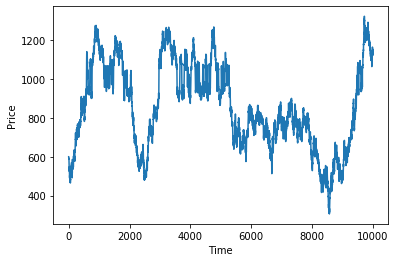

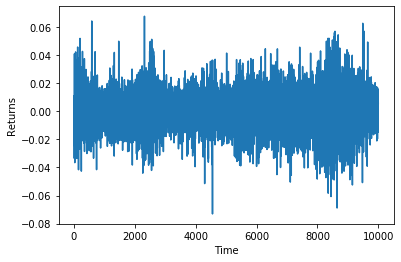

In [2]:
# %load gaunersdorfer_hommes/gaunersdorfer_hommes.py

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)

T = 10000     #Time Horizon
# For GHW model with low D chaos set chaos = 1
# For GH  model with limit cycle and realistic price dynamics set chaos = 0

# The model is written with the dynamics in terms of deviations
# from the constant fundamental given by pbar
# as x(t) = p(t)-pbar
# this is both a little simpler, and turns out to be a better
# thing to do numerically.  See notes for some details

chaos = 0

# a*sigma(risk aversion * variance)
asig = 1
ybar = 1

if chaos == 1:
    T = 500
    r = 0.01
    pstar = ybar/r
    beta = 4
    v = 0.3
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4 # chaos
    eta = 0
    # std for price noise
    epssig = 0
    alpha = 10
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    riskAdjust = 1
    # starting price level
    startx = 0.01
else:
    r = 0.001
    pstar = ybar/r
    beta = 2
    v = 1
    g = 1.9
    alpha = 1800
    eta = 0.99
    riskAdjust = 0
    epssig = 10
    startx = -400

n2 = np.zeros([T, 1])       # Fraction of type 2
p = np.zeros([T, 1])        # Price
R = np.zeros([T,1])         # Per share Return
# x = deviation from fundamental (pstar)
x = np.zeros([T,1])         # p - pstar (used in most dynamics)
u1 = np.zeros([T,1])        # type 1 accumulated realized profits
u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
z1 = 0.5 * np.ones([T,1])   # share holdings type 1
z2 = 0.5 * np.ones([T,1])   # share holdings type 2
eps = epssig * np.random.randn(T) # additive pricing noise
nn = np.zeros([T,1])

# initial value

# fraction of agents
n2[0] = 0.5
n2[1] = n2[0]
n2[2] = n2[1]
n2[3] = n2[2]

# x = price - pstar
x[0] = startx
x[1] = x[0]
x[2] = x[1]
x[3] = x[2]

p = pstar + x

# start at t = 5 to allow for lags
for t in range(4,T):
    # update utility
    # simplified equation from paper(see GHW equation(12))
    # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
    # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
    # detaled one period profits using last period holdings
    pi1 = R[t-1]* z1[t-2] - riskAdjust * 0.5 * asig * z1[t-2]**2
    pi2 = R[t-1]* z2[t-2] - riskAdjust * 0.5 * asig * z2[t-2]**2
    # accumulated fitness
    u1[t-1] = pi1 + eta * u1[t-2]
    u2[t-1] = pi2 + eta * u2[t-2]
    # normalization for logistice
    norm = np.exp( beta * u1[t-1]) + np.exp( beta * u2[t-1])
    nn[t] = norm
    # basic n2tilde (before adjustment)
    n2tilde = np.exp( beta * u2[t-1]) / norm
    # emergency check to make sure still in range, if not set to 0.5
    if np.isnan(n2tilde):
        n2tilde = 0.5
    # adjustment to n, see paper
    n2[t] = n2tilde * np.exp( -(x[t-1]) ** 2 / alpha)
    # x(t+1) ( p(t+1)) forecasts
    exp1 = v * (x[t-1]) # type 1 price forecast for t+1
    exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
    # new price for today from t+1 forecasts (note timing)
    x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
    p[t] = x[t] + pstar
    # returns time path
    # R[t-1] = p[t+1] - pstar - (1+r)*(p[t]-pstar) + dstd*np.randn(1)
    R[t] = x[t] - x[t-1]
    # portfolio decisions
    z1[t] = ( exp1 - x[t])/asig
    z2[t] = ( exp2 - x[t])/asig

# log return
lret = np.log(p[1:T]) - np.log(p[0:T-1])
# arithmetic return
ret = p[1:T] / p[0:T-1]-1
ghret = p[1:T] - ybar - (1+r) * p[0:T-1]


# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(range(T), p[0:])
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# plot returns
fig_r, ax_r = plt.subplots()
ax_r.plot(range(T-1), lret[0:] )
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()


Above we loaded the original code more-or less exactly as copied from the LeBaron book (I have removed its original author's name to slightly protect the innocent, but the original can be found [here](http://people.brandeis.edu/~blebaron/classes/agentfin/GaunersdorferHommes.html)).

We then executed it and checked that it worked, producing two plots that look similar to those discussed in the book (note: I also get a minor floating-point warning, possibly related to some out-of-bounds floating-point values; I have not taken the time to investigate this yet but it probably means there are some NaNs in the output).  In the [simcluster](https://github.com/embray/notebooks/blob/master/simcluster.ipynb) tutorial we began by taking some straightforward code like this and convert to an easily reusable command-line script.  We will skip that use case for the time being (though you can have a look at the other tutorial for some times on that).  And instead we'll move straight to some *refactoring* to make this code more modular.

In the process of refactoring this code I'll make several changes in different steps.  Not every individual step I took is shown directly in this notebook.  However, when I first made a pass at refactoring this code I did so in a Git repository, and made commits for each distinct change I made, so if you want to follow my thinking step-by-step you can do so by looking through the [commit history for this code](https://github.com/embray/agentfin/commits/master/gaunersdorfer_hommes).

### Initial refactoring

Looking at this short code, we can identify a few main sections to it.  One possible way of looking at it could be:

1. Preamble: Importing external module dependencies, and expository comments.
2. Configuration: Defining the parameters to our model.
3. Model: Actual implementation of the algorithm, taking the configured parameters as inputs and producing some results (prices and returns simulated by the model) that are referenced by variables (`p`, `ret`, `lret`, and `ghret` in this case, as well as some other intermediate results that can be accessed through global variables, such as `x` giving the value of $ p_t - p^* $ at each time step).
4. Plotting: A few plots of some of our results.

A couple observations we might make for initial steps to make this code more modular: What if we want to re-run the simulation, but tweak the parameters a bit?  We would have to edit this source code to change the parameters each time.  What if we want to go back-and-forth with experimenting with different results from different parameters, without losing track of which parameters produced which results?  Also what if we want to make more different kinds of plots?  Or no plots at all?  What if we just want to be able to run our simulation on its own and do something with the results later?'

The initial solution to all these questions is that we can take the implementation of our model, particularly sections "2" and "3", and put it in a *function* that we can call repeatedly, possibly with varying parameters:

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:167: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide


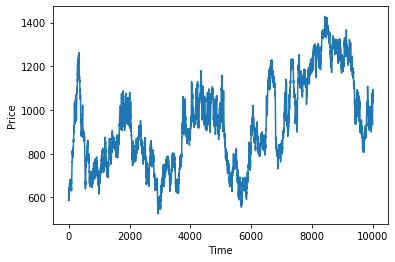

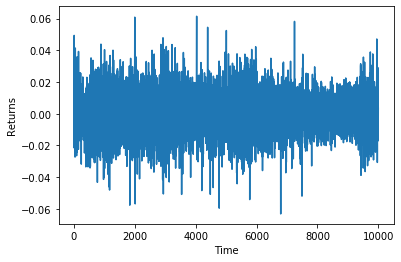

In [3]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


p, lret, ret, ghret = gaunersdorfer_hommes()


# plot price
fig_p, ax_p = plt.subplots()
ax_p.plot(np.arange(len(p)), p)
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()

# plot returns
fig_r, ax_r = plt.subplots()
ax_r.plot(np.arange(len(lret)), lret)
plt.xlabel('Time')
plt.ylabel('Returns')
plt.show()

In the above version of the code, in addition to other minor tweaks, the *main* change is that the meat of the model code was moved into its own *function* named `gaunersdorfer_hommes()`.  Although one could take many different approaches to this, in this case I decided that it should take no *required* arguments.  All of the default parameters are given in global variables (`GH_DEFAULTS` and `GH_DEFAULTS_CHAOS`).  When we call the function we *may* override any of those defaults by passing them as keyword arguments (this is the `**kwargs`), like `gaunersdorfer_hommes(r=0.015)`.  But otherwise the defaults are used.

One driver of this particular design is that I noted that the original authors give two sets of parameters they'd like us to try, depending on whether or not we want to include additional random noise in the simulation.  Thus I put each set of default parameters in its own global variable, and we can select which set of defaults to start with by passing `chaos=False` (the default) or `chaos=True`).  This is just one possible approach that hews close to the original implementation, but makes it easier for us to try both versions of the simulation without modifying anything else (i.e. directly modifying the code to set the `chaos` option, as the original code asked us to do):

In [4]:
gaunersdorfer_hommes()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:167: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: overflow encountered in exp
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:170: RuntimeWarning: invalid value encountered in true_divide


(array([[ 600.        ],
        [ 600.        ],
        [ 600.        ],
        ...,
        [1201.91215786],
        [1191.66550214],
        [1190.32959165]]), array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.01467106],
        [-0.00856184],
        [-0.00112167]]), array([[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        ...,
        [-0.01456397],
        [-0.0085253 ],
        [-0.00112104]]), array([[ -1.6       ],
        [ -1.6       ],
        [ -1.6       ],
        ...,
        [-19.98299122],
        [-12.44856788],
        [ -3.52757599]]))

In [5]:
# For some reason the display of the results is not being
# truncated by Numpy in this case, so well just manually
# truncated it for demonstration purposes...
gaunersdorfer_hommes(chaos=True)[0].flatten()[:10]

array([100.01      , 100.01      , 100.01      , 100.01      ,
       100.00643561,  99.99990682,  99.99218377,  99.98579318,
        99.98326199,  99.98621989])

Otherwise, the rest of the above example works exactly the same as the original: We now directly *call* the `gaunersdorfer_hommes()` function once, assigning its return values to variables, and then executing "module level" code to produce the plots.

What if we just want to write the code such that we can define and call `gaunersdorfer_hommes()` without necessarily creating any plots, or perhaps using the results to create different plots, or perform some other kind of statistical analysis?

The next step then would be to get rid of *all* code that runs directly in the module, and instead just define some functions for the plots as well (taking as input some arrays that *might* have been returned by `gaunersdorfer_hommes()` but could in principle be any arbitrary NumPy array):

In [6]:
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


def plot_price(price):
    fig_p, ax_p = plt.subplots()
    ax_p.plot(np.arange(len(price)), price)
    plt.xlabel('Time')
    plt.ylabel('Price')
    return fig_p


def plot_returns(lret):
    fig_r, ax_r = plt.subplots()
    ax_r.plot(np.arange(len(lret)), lret)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    return fig_r

Now when we execute the above example, there is no output.  That's because the plots are now wrapped in function definitions as well, and no functions are *called* in the above code.  Only *defined*.  This is our first real step towards modularity and reuse.  In fact as is this would be a perfectly good Python module to distribute and use by running (e.g. at a Python interactive prompt):


    >>> import gaunersdorfer_hommes
    >>> gaunersdorfer_hommes.gaunersdorfer_hommes()
    
or equivalently:

    >>> from gaunersdorfer_hommes import gaunersdorfer_hommes
    >>> import gaunersdorfer_hommes
 
(Perhaps we could also give it a snappier name in case we get tired of writing "gaunersdorfer_hommes" over and over, though this name has the advantage of being fairly unique (as opposed to something very generic and inspecific like "model"), and IPython/Jupyter and other IDEs provide auto-completion features, so maybe it's not too bad.)

In fact, let's go ahead and try it!  We can write the contents of a notebook cell directly to a file by placing `%%file <filename>` at the top of the cell and executing it (which saves the cell contents to the given filename rather than running the cell):

In [7]:
%%file gaunersdorfer_hommes.py
# -*- coding: utf-8 -*-

import numpy as np
import matplotlib.pyplot as plt
import time

# A Nonlinear Structural Model for Volatility Clustering
# This program is designed to duplicate the results found by
# Andrea Gaunersdorfer & Cars Hommes
# It also builds off the earlier results from
# Gaunersdorfer, Hommes, Wagener, Journal of Economic Behavior and
# Organization, Vol 67, 27-47: 2008

# Type 1 agents hold fundamentalist beliefs
# Type 2 agents are trend followers
# E1t[pt+1] = p* + v(pt-1 - p*)
# E2t[pt+1] = pt-1 + g(pt-1 - pt-2)


# α*σ (risk aversion * variance)
# Note: Because Python 3 supports most unicode characters in variable names we
# could actually name this variable:
#
# ασ = 1
#
# Though it would probably be less convenient to type.  Similarly with ȳ = 1.
#
# For use in this simulation, these values are assumed constant 1, and won't
# generally change.  If there is a reason to change them we could make them
# additional paramters of the simulation, but for the purpose of demonstration
# we will make them global "constants", which in Python are typically written
# in ALL_CAPS to distinguish that they are "constant" (of course the Python
# language does not actually prohibit us from changing them).
A_SIG = 1.0
Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations
    from the constant fundamental given by pbar
    as x(t) = p(t)-pbar
    this is both a little simpler, and turns out to be a better
    thing to do numerically.  See notes for some details.

    T = Time Horizon
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret


def plot_price(price):
    fig_p, ax_p = plt.subplots()
    ax_p.plot(np.arange(len(price)), price)
    plt.xlabel('Time')
    plt.ylabel('Price')
    return fig_p


def plot_returns(lret):
    fig_r, ax_r = plt.subplots()
    ax_r.plot(np.arange(len(lret)), lret)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    return fig_r

Overwriting gaunersdorfer_hommes.py


In [8]:
import gaunersdorfer_hommes

In [9]:
gaunersdorfer_hommes

<module 'gaunersdorfer_hommes' from '/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py'>

In [10]:
price, lret, ret, ghret = gaunersdorfer_hommes.gaunersdorfer_hommes()

/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:167: RuntimeWarning: overflow encountered in exp
  norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:170: RuntimeWarning: overflow encountered in exp
  n2tilde = np.exp(beta * u2[t-1]) / norm
/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:170: RuntimeWarning: invalid value encountered in true_divide
  n2tilde = np.exp(beta * u2[t-1]) / norm


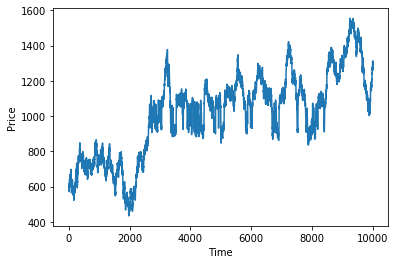

In [11]:
figure = gaunersdorfer_hommes.plot_price(price)

In [12]:
# Perhaps we want to save the plot to a file for later use:
# The plot_price() function as designed returns the figure object
# so that we can easily do this and other post-processing with
# the default plot, if so desired.
figure.savefig('gh_prices.png')

### An aside about modules and sys.path

If you have a Python script named `foobar.py`, and you run that script at the command-line like `python foobar.py`, one can see in a straightforward manner that the Python interpreter simply executes the lines of the script one by one until it reaches the end of the script, then exits (assuming no errors occur, or infinite loops).

There is, however, another way to execute a `.py` file, and that's by *importing* it as a *module* using the `import` statement, just as we did above with `import gaunersdorfer_hommes`.  In this case the module is executed line-by-line much in the same way, but how it is used is different.  Before the module is executed a special *namespace* is created for it in the form of a `module` object.  You won't normally create or interact with `module` objects often like you do with other types of Python objects, but it's worth mentioning that in some sense a module is just another object.  When you do `import foobar`, it's a little as if you ran (in some pseudocode) `foobar = load_module_in_namespace('foobar.py')`.  That is, `import foobar` actually creates a variable named `foobar` referencing the module.

The point of the module is that as `foobar.py` is executed, any functions or classes that are defined, and any global variables that are created, are assigned to the module namespace for us to access later, just as we did we were able to do above.  There's otherwise nothing that special about importing a Python file.  Any code that's in it (including code with side-effects, such as print statements) are run at import time.

So to create your own modules all you do is write your own `.py` file, define some objects in it, and then you can import it by running `import <module_name>`, where `<module_name>` is the same as the filename, but with the `.py` extension omitted. Let's try it with another example:

In [13]:
%%file foobar.py
"""A useless module."""

print("Importing foobar!")

foo = 1

def bar():
    return 2

Overwriting foobar.py


In [14]:
import foobar

Importing foobar!


In [15]:
foobar.foo

1

In [16]:
foobar.bar()

2

In [17]:
# The module object itself has some attributes of possible interest for inspection
print(foobar.__name__)
print(foobar.__file__)
print(foobar.__doc__)
# Among others...

foobar
/home/embray/src/agentfin/notebooks/foobar.py
A useless module.


If some module isn't working the way you expected it to (e.g. a function is missing that you're sure you defined) try printing `module_name.__file__` as we did just above to make sure `import module_name` is actually importing the file you think it's importing.

This raises an interesting question:  We know that when we run `import foobar`, Python is searching for a file named `foobar.py`.  But where is it searching for it?  What if I have more than one file named `foobar.py` somewhere?  Does it look over my entire computer for it?  Certainly not--that would take forever, and could be dangerous.

Rather, for this purpose, Python uses a special internal variable called `sys.path`.  In my case it looks like this (on your computer, depending on the OS and the Python distribution it may look different):

In [18]:
import sys
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/embray/.local/lib/python3.6/site-packages',
 '/home/embray/src/psutil',
 '/usr/lib/python3.6/site-packages',
 '/usr/lib/python3.6/site-packages/IPython/extensions',
 '/home/embray/.ipython']

What we get is a list of directory names.  These are the directories that Python searches in for modules (in my case there is also a `python36.zip` file--Python can also search for modules inside zip files, though this is rarely used execept for special purposes).

So upon `import foobar` Python goes through each of those directories in order until it finds a `foobar.py` in of them, and then stops at the first one (there are some other things that can also be recognized as the `foobar` module, such as a package, which we'll look at in a bit).

Not having a solid grasp on `sys.path` and how it works can lead to a few common beginner mistakes involving getting confused about what paths their files on.  In particular, one of the default `sys.path` entries is almost always the empty string `''`.  In the case of `sys.path` this actually represents the *current working directory*.  This is why we were able, from this notebook, to write out `foobar.py` and then immediately import it.  We wrote it directly to our current directory so we can import it as `foobar`:

In [19]:
import os; os.listdir('.')

['.gitignore',
 'foobar.py',
 'gaunersdorfer_hommes.ipynb',
 'gaunersdorfer_hommes.py',
 'gh_prices.png',
 '__pycache__']

If we changed directories we wouldn't be able to import it anymore.  We'll demonstrate this in a new Python interpreter:

In [20]:
import shlex
import sys
import subprocess as sp

# A little utility we'll keep using to run some code in a new Python
# interpreter and print its output.  If this is confusing don't get
# too distracted by it.
#
# This is equivalent to running at the command line:
#
#     $ python -c '<code>' 2>&1
#
def python(args='', **kwargs):
    if sys.platform == 'win32':
        # Different approaches to this work better whether on Windows or POSIX
        cmd = f'{sys.executable} {args}'
    else:
        cmd = [sys.executable] + shlex.split(args)
    print(sp.run(cmd,
          encoding='utf8', stdout=sp.PIPE, stderr=sp.STDOUT,
          **kwargs).stdout)
    
# This should work: sys.executable points to the same python executable
# This just runs a new python and executes the code
# "import foobar; print(foobar.foo)"
python('-c "import foobar; print(foobar.foo)"')

Importing foobar!
1



In [21]:
# This does the same thing again, but we pass cwd='..' to subprocess.run
# to change out of the current directory before running the new Python
python('-c "import foobar; print(foobar.foo)"', cwd='..')

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'foobar'



An especially painful beginner trap is when you have `.py` file in your current
directory that has a generic name that happens to coincide with another common
module that other code you use depends on.  I've seen this for example when someone
writes a bunch of routines that write to files, and names it `io.py`.  This will
completely break any other code that relies on the standard `io` module.  Fortunately
some Python environments and distributions will arrange things so that standard
library modules are never overshadowed, but this is not always a guarantee.

As one more little exercise, let's try *modifying* our `foobar.py` file and then re-importing it:

In [22]:
%%file foobar.py
print("This really ought to be printed when we import foobar!")

foo = 42

def bar():
    return 3

Overwriting foobar.py


In [23]:
import foobar

Alas, nothing is printed like it was last time.  Also, didn't we change the value of `foo` to `42`?

In [24]:
foobar.foo

1

It seems that we are using an older version of the `foobar` module, even though we just edited it.  In fact,
this demonstrates another gotcha that's worth being aware of when writing and working with modules: When you
import a module Python *caches* the result, so that within the same interpreter session future attempts to
`import foobar` are no-ops.  If we ran a different Python (e.g. at the command-line, or by restarting the
Jupyter kernel), it would work:

In [25]:
! python -c "import foobar"

This really ought to be printed when we import foobar!


There is an easy way to work around this though, at least for simple modules that don't have any dependencies.  The place where the modules are cached is another special built-in variable called [sys.modules](https://docs.python.org/3/library/sys.html#sys.modules) which is a dictionary that we are free to poke around in and modify:

In [26]:
import sys
sys.modules['foobar']

<module 'foobar' from '/home/embray/src/agentfin/notebooks/foobar.py'>

An easy, portable way to force reloading the `foobar` module is to simply delete its cached entry from `sys.modules`:

In [27]:
del sys.modules['foobar']

In [28]:
import foobar

This really ought to be printed when we import foobar!


In [29]:
foobar.foo

42

However, use this trick with *extreme caution!*  If you already imported some modules which are *dependent* on your module, and you reload your module in this way, the dependent modules will still be using the *old version* of the module, and will have to be reloaded as well, and so on recursively through the dependency tree.  There is no good way built into Python to do this thoroughly and it turns out to be a hard problem in general.  So the safest thing to do when modifying a module (if anything else depends on it) is just restart Python, unfortunately.

Note: Something I often see researchers struggling with is managing `sys.path` and their Python modules in such a way that they are able to import them.  I often see code that manually adds hard-coded entries to `sys.path`, such as adding the path on their computer to all their Python modules so they can be found when they import each other.  Or similarly manipulating `PYTHONPATH`, a special environment variable that adds new entries to `sys.path`.

When following best practices this kind of path manipulation and worrying about where files are should *almost never* be necessary (at least for the case of running `import`; if you have scripts you need to at least know where to script is, though even that can be avoided).

Unfortunately, the best solution to this problem requires learning a number of concepts, including how to make Python package distributions, and how to use programs like `pip`.  It is also very helpful to have concepts like "virtual environments" (or equivalently conda environments if you are using [conda](https://docs.conda.io/en/latest/).  It can be a lot.  We'll go over some of these techniques toward the end.

### Getting back to the refactoring: creating a package

We might note, next, that our `gaunersdorfer_hommes.py` contains two distinct pieces of functionality in the same file:  The implementation of the actual model, and some useful plotting routines.  The plotting routines are actually pretty generic and not specific to this model, so we might consider moving them to their own file, say `plotting.py`.

This is a slightly contrived example since it's already a reasonably small file, but in real code something like plotting code alone can get complex enough that it should be in its own file to not distract from implementation of the model itself.  Of course the models can get more complex themselves, and require various utility modules.

Of course, we might also want a little shortcut script to run our model and generate some plots (just as in the original code) so we'll write three files: `gaunersdorfer_hommes.py` (the model itself), `plotting.py` (our plotting utilities), and `example.py`, an example script tying them all together:

In [30]:
%%file gaunersdorfer_hommes.py
# -*- coding: utf-8 -*-

"""
A Nonlinear Structural Model for Volatility Clustering This program is designed
to duplicate the results found by Andrea Gaunersdorfer & Cars Hommes
`cite:GH2007`.

It also builds off the earlier results from Gaunersdorfer, Hommes, Wagener,
Journal of Economic Behavior and Organization, Vol 67, 27-47: 2008
`cite:GHW2008`.

* Type 1 agents hold fundamentalist beliefs
* Type 2 agents are trend followers

.. math::

    E_{1,t}[p_{t+1}] = p^* + v(p_{t-1} - p^*)
    E_{2,t}[p_{t+1}] = p_{t-1} + g(p_{t-1} - p_{t-2})
"""

import numpy as np


A_SIG = 1.0
"""
α*σ (risk aversion * variance)

..note::

    Because Python 3 supports most unicode characters in variable names we
    could actually name this variable: ``ασ = 1``.  Though it would probably be
    less convenient to type.  Similarly with ``ȳ = 1``.

For use in this simulation, these values are assumed constant 1.0, and won't
generally change.  If there is a reason to change them we could make them
additional paramters of the simulation, but for the purpose of demonstration we
will make them global "constants", which in Python are typically written in
``ALL_CAPS`` to distinguish that they are "constant" (of course the Python
language does not actually prohibit us from changing them).
"""

Y_BAR = 1.0


# Default parameters without chaos (chaos=False)
GH_DEFAULTS = dict(
    T = 10000,
    r = 0.001,
    beta = 2,
    v = 1.0,
    g = 1.9,
    alpha = 1800,
    eta = 0.99,
    risk_adjust = 0,
    eps_sig = 10,
    start_x = -400
)


# Default parameters with chaos
GH_DEFAULTS_CHAOS = dict(
    T = 500,
    r = 0.01,
    beta = 4,
    v = 0.3,
    # g == 2.00 # fixed point
    # g = 2.09 # limit cycle
    g = 2.4,  # chaos
    eta = 0,
    # std for price noise
    eps_sig = 0,
    alpha = 10,
    # set to one for risk adjustment trading profits(done differnently in the
    # two papers)
    risk_adjust = 1,
    # starting price level
    start_x = 0.01
)


def gaunersdorfer_hommes(chaos=False, **kwargs):
    """
    Gaunersdorfer and Hommes model.

    All parameters are optional and have default values set below.  The default
    value for each parameter depends on whether or not ``chaos=True``.

    For GHW model with low D chaos set ``chaos=True``.
    For GH model with limit cycle and realistic price dynamics set
    ``chaos=False``.

    The model is written with the dynamics in terms of deviations from the
    constant fundamental given by :math:`p^*` (represented in the code by the
    variable ``p_star``) as

    .. math::

        x_t = p_t - p^*

    this is both a little simpler, and turns out to be a better thing to do
    numerically.  See notes for some details.

    Parameters
    ----------

    chaos : bool, optional
        If ``chaos=True`` (default ``False``) set the default parameters for a
        model with low-D chaos.
    T : int, optional
        Time horizon of the simulation.  With ``chaos=False`` the default is
        ``T=10000``.

    ...
    """

    if chaos:
        # Important to call .copy() or else we will accidentally modify the
        # original default dicts below
        params = GH_DEFAULTS_CHAOS.copy()
    else:
        params = GH_DEFAULTS.copy()

    # If the user passed any additional arguments as keyword arguments, we
    # replace the defaults with the user's arguments here.
    params.update(kwargs)

    # Now read out local variables from the defaults (as a trick, we could also
    # do this in one line by running `locals().update(params)`.  `locals()`
    # returns the dictionary that actually stores the local variables for our
    # function, and we can directly update it just like any other dict.
    # However, this can also be a bit dangerous (what if a user passes a
    # parameter that accidentally overrides a local variable that was not
    # intended to be passed as a parameter?)
    T = params['T']
    r = params['r']
    beta = params['beta']
    v = params['v']
    g = params['g']
    eta = params['eta']
    eps_sig = params['eps_sig']
    alpha = params['alpha']
    risk_adjust = params['risk_adjust']
    start_x = params['start_x']

    p_star = Y_BAR / r

    # Now we can set up the rest of the simulation from the given parameters:
    n2 = np.zeros([T, 1])       # Fraction of type 2
    p = np.zeros([T, 1])        # Price
    R = np.zeros([T, 1])         # Per share Return
    # x = deviation from fundamental (p_star)
    x = np.zeros([T, 1])         # p - p_star (used in most dynamics)
    u1 = np.zeros([T, 1])        # type 1 accumulated realized profits
    u2 = np.zeros([T, 1])       # type 2 accumulated realized profits
    z1 = 0.5 * np.ones([T, 1])   # share holdings type 1
    z2 = 0.5 * np.ones([T, 1])   # share holdings type 2
    eps = eps_sig * np.random.randn(T) # additive pricing noise
    nn = np.zeros([T,1])

    # initial value

    # fraction of agents
    n2[0] = 0.5
    n2[1] = n2[0]
    n2[2] = n2[1]
    n2[3] = n2[2]

    # x = price - p_star
    x[0] = start_x
    x[1] = x[0]
    x[2] = x[1]
    x[3] = x[2]

    p = p_star + x

    # start at t = 5 to allow for lags
    for t in range(4, T):
        # update utility
        # simplified equation from paper(see GHW equation(12))
        # u1(t) = -0.5*(x(t-1)-v*x(t-3))^2;
        # u2(t) = -0.5*(x(t-1) - x(t-3) - g*(x(t-3)-x(t-4)))^2;
        # detaled one period profits using last period holdings
        pi1 = R[t-1] * z1[t-2] - risk_adjust * 0.5 * A_SIG * z1[t-2]**2
        pi2 = R[t-1] * z2[t-2] - risk_adjust * 0.5 * A_SIG * z2[t-2]**2
        # accumulated fitness
        u1[t-1] = pi1 + eta * u1[t-2]
        u2[t-1] = pi2 + eta * u2[t-2]
        # normalization for logistice
        norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
        nn[t] = norm
        # basic n2tilde (before adjustment)
        n2tilde = np.exp(beta * u2[t-1]) / norm
        # emergency check to make sure still in range, if not set to 0.5
        if np.isnan(n2tilde):
            n2tilde = 0.5
        # adjustment to n, see paper
        n2[t] = n2tilde * np.exp(-(x[t-1]) ** 2 / alpha)
        # x(t+1) ( p(t+1)) forecasts
        exp1 = v * (x[t-1]) # type 1 price forecast for t+1
        exp2 = x[t-1] + g * (x[t-1]-x[t-2]) # type 2 price forecast for t+1
        # new price for today from t+1 forecasts (note timing)
        x[t] = 1/(1+r) * (((1-n2[t])* exp1 + n2[t]*exp2 ) + eps[t])
        p[t] = x[t] + p_star
        # returns time path
        # R[t-1] = p[t+1] - p_star - (1+r)*(p[t]-p_star) + dstd*np.randn(1)
        R[t] = x[t] - x[t-1]
        # portfolio decisions
        z1[t] = (exp1 - x[t]) / A_SIG
        z2[t] = (exp2 - x[t]) / A_SIG

    # log return
    lret = np.log(p[1:T]) - np.log(p[0:T-1])
    # arithmetic return
    ret = p[1:T] / p[0:T-1]-1
    ghret = p[1:T] - Y_BAR - (1+r) * p[0:T-1]

    # We return the array of prices and arrays of returns.
    # We could also return other intermediate results as needed.
    # Some functions in scipy, for example, take additional arguments which
    # affect exactly which results are returned, and which ones are thrown
    # away.  Or others may take a single flag to optionally return extended
    # result parameters in a dict.
    # See for example scipy.optimize.least_squares for an example interface
    # with many inputs, and many non-trivial outputs:
    # https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.least_squares.html#scipy.optimize.least_squares
    return p, lret, ret, ghret

Overwriting gaunersdorfer_hommes.py


(Note: The above version includes a few additional new enhancements, such as improved *docstrings* which we can use to auto-generate API documentation.  This will be left as a separate exercise.)

In [31]:
%%file plotting.py
import numpy as np
import matplotlib.pyplot as plt


def plot_price(price):
    fig_p, ax_p = plt.subplots()
    ax_p.plot(np.arange(len(price)), price)
    plt.xlabel('Time')
    plt.ylabel('Price')
    return fig_p


def plot_returns(lret):
    fig_r, ax_r = plt.subplots()
    ax_r.plot(np.arange(len(lret)), lret)
    plt.xlabel('Time')
    plt.ylabel('Returns')
    return fig_r

Writing plotting.py


Additional aside: Since we moved the plotting code to a separate module, or main `gaunersdorfer_hommes.py` module no longer has a dependency on `matplotlib`.  This could allow us to easily make the dependency on matplotlib optional, in case someone wants to use our model but doesn't care about using our pltting code.

In [32]:
%%file example.py

from gaunersdorfer_hommes import gaunersdorfer_hommes
from plotting import plot_price, plot_returns

def run(prices_filename=None, returns_filename=None):
    p, lret, ret, ghret = gaunersdorfer_hommes()

    fig = plot_price(p)
    if prices_filename:
        fig.savefig(prices_filename)

    fig = plot_returns(lret)

    if returns_filename:
        fig.savefig(returns_filename)
        
        
if __name__ == '__main__':
    # Note: We will explain this as time permits; otherwise just
    # put "__name__ == __main__" into your search engine or see
    # https://stackoverflow.com/a/419185/982257
    run(prices_filename='prices.png', returns_filename='returns.png')

Writing example.py


In [33]:
# We can try running example.py now as a Python script:
python("example.py")

/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:189: RuntimeWarning: overflow encountered in exp
  norm = np.exp(beta * u1[t-1]) + np.exp(beta * u2[t-1])
/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:192: RuntimeWarning: overflow encountered in exp
  n2tilde = np.exp(beta * u2[t-1]) / norm
/home/embray/src/agentfin/notebooks/gaunersdorfer_hommes.py:192: RuntimeWarning: invalid value encountered in true_divide
  n2tilde = np.exp(beta * u2[t-1]) / norm



In [34]:
import os
os.listdir('.')

['.gitignore',
 'example.py',
 'foobar.py',
 'foobar.pyc',
 'gaunersdorfer_hommes.ipynb',
 'gaunersdorfer_hommes.py',
 'gh_prices.png',
 'plotting.py',
 'prices.png',
 'returns.png',
 '__pycache__']

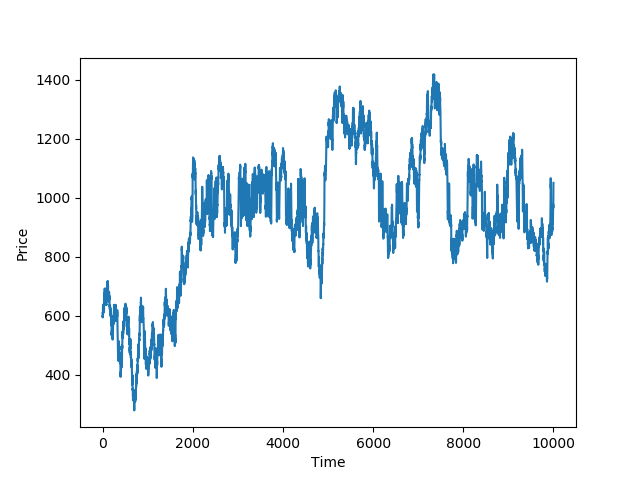

In [35]:
from IPython.display import display, Image
display(Image('prices.png'))

This all works, but it has the problem we mentioned before with `sys.path`.  Our `example.py` script imports from our other two modules, and that only works because they happen to be in our current directory.  If we changed directories and tried to run our example script from a different path we *might* be in trouble.

In fact in this case it does work--in modern Python versions if you execute a script, it puts the directory that script lives in on `sys.path`.  However, if the script were in a different directory from our support modules, it would not work.

Nevertheless, although this works, it's still a bit messy.  We have multiple Python files floating around, and this could get only worse as our project grows.  This case is not so bad, but it quickly gets worse with three or four files.  See for example the [chiarella](https://github.com/embray/agentfin/tree/master/sample_packages/chiarella) sample, again taken from LeBaron, which would make for a good exercise in repackaging a multiple module project.

But even our current example has problems as-is. "plotting" is a fairly generic name for a module, and could easily be overshadowed by someone else's (or even your own, in another project) "plotting" module. "gaunersdorfer_hommes" may be reasonably unique--let's say we've spent some time Googling around to see if anyone else has published a Python project called "gaunersdorfer_hommes" (in particular we should check the Python Package Index, or [PyPI](https://pypi.org/) for the name). But what do want to bet there are other projects out there that have a name like "plotting"? This can be a bit subjective, but a generic name like that is usually bad, as it's easy to conflict with something else.

A common example we already mentioned is when someone puts a bunch of string-related functions into a module called "io.py". It turns out the Python standard library also has a module called `io`, but if you have a file called "io.py" on your current working directory, any Python code, including code in the standard library, that calls `import io` will use your `io` module instead of the real one. Python will break in wild and bizarre ways. So be careful when naming modules that it's not something you can already import.

To get around this we could do some namespacing at the filename level. For example we might rename "plotting.py" to "mymodels_plotting.py". But now we have a longer filename, and this can become tedious (especially when we want even deeper levels of nesting--I have projects that contain several files called "utils.py"). We already have a nicer way to do namespacing built into our filesystem: directories!

The idea of a Python *package* is that it allows us to organize a collection of related Python modules into a directory, and this creates a namespace that is the name of that directory. The idea here is that we take our our ".py" files into a directory, and then instead of importing a file, we in a sense import the name of that directory. Every module in that directory is imported by joining the directory name and the module name with a `.`. So just as a Python module creates a namespace of functions, a package creates namespace of modules.

For example to make our current project into a package (let's call it "mymodels", which is still not a great name for publishing, but good enough for private use) we would make a directory called "mymodels", and then move "gaunersdorfer_hommes.py" and "plotting.py" into that directory. Now instead of typing `import plotting` we type `import mymodels.plotting`. The original "gaunersdorfer_hommes" is imported now as `mymodels.gaunersdorfer_hommes`. Here already we begin to see some potential: Perhaps we could add other, similar financial models to our `mymodels` package (left as an exercise).

We'll also reorganize a bit and put our example script into an "examples" directory living outside the package (this will also serve us well if our project includes multiple example scripts).

In [36]:
import os
if os.path.exists('mymodels'):
    raise RuntimeError(
        'The following example creates a package named "mymodels", but a '
        'file/directory named "mymodels" already exists!  Please delete the '
        'existing mymodels to continue with the example.')

    
# Make the examples directory and move example.py there
if not os.path.exists('examples'):
    os.mkdir('examples')
    
if os.path.exists('example.py'):
    filename = os.path.join('examples', 'example.py')
    if os.path.exists(filename):
        os.remove(filename)
    os.rename('example.py', filename)
    
# Make a directory for our mymodels package
if not os.path.exists('mymodels'):
    os.mkdir('mymodels')

# Finally, move our .py modules into the package:
for filename in ['gaunersdorfer_hommes.py', 'plotting.py']:
    if os.path.isfile(filename):
        dest = os.path.join('mymodels', filename)
        if os.path.isfile(dest):
            os.remove(dest)
        os.rename(filename, dest)

As one final step to converting our code into a *package*, we create a special file in the `mymodels` directory called `__init__.py`.  On Python 3 this step is no longer necessary: Any directory containing Python modules becomes a package automatically.  However, if you still need to support Python 2 it's good to know this.  Also, `__init__.py` files are still supported in Python 3 and can be useful for other reasons as we will see later (one use used right below is to provide a docstring for our package).

In [37]:
%%file mymodels/__init__.py
"""A docstring for the mymodels package."""

Writing mymodels/__init__.py


If everything is done properly we should have something that looks like this:

    ├── examples
    │   └── example.py
    ├── mymodels
    │   ├── __init__.py
    │   ├── gaunersdorfer_hommes.py
    │   └── plotting.py


Importing packages works just like importing `.py` modules.  Python scans `sys.path` in the same way, and imports the first thing it finds (whether a plain module with a name like `mymodels.py`, or a package) and imports that.  In fact, a package is just a special kind of module that contains sub-modules:

In [38]:
import mymodels
mymodels

<module 'mymodels' from '/home/embray/src/agentfin/notebooks/mymodels/__init__.py'>

In [39]:
print(mymodels.__doc__)

A docstring for the mymodels package.


One way in which packages are slightly different from plain `.py` modules, which is a trap for beginners, is that you might now expect this to work, but it doesn't always:

In [40]:
mymodels.gaunersdorfer_hommes.gaunersdorfer_hommes()

AttributeError: module 'mymodels' has no attribute 'gaunersdorfer_hommes'

This is because when you import a package, it does *not* automatically import all of the package's sub-modules into the package namespace.  This is surprising, but it's done this way for a very practical reason:  Many packages, including many popular packages like `numpy` and `scipy` can be *huge*, consisting of dozens or even hundreds of sub-packages and sub-modules.  Most users want it to be quick when then run `import scipy`, and are usually only using a few pieces from the library, so they don't need or want to waste time and computer memory loading the entire kitchen sink.

Therefore, large packages like this can control exactly what common functionality is loaded into their namespaces by default, without loading every piece of the package recursively.

We can do this for ourselves.  Say we want to use our `gaunersdorfer_hommes()` regularly, and don't want the extra repetition of typing `mymodels.gaunersdorfer_hommes.gaunersdorfer_hommes()`.  This is another use for `__init__.py`.  Anything we define or import in the `__init__.py` file is made available as the package's top-level namespace:

In [41]:
%%file mymodels/__init__.py
"""A docstring for the mymodels package."""

from .gaunersdorfer_hommes import gaunersdorfer_hommes

def toy_model():
    """Just for example."""

Overwriting mymodels/__init__.py


In [42]:
try:
    del sys.modules['mymodels']  # To reload the package
except KeyError:
    pass

# Now try importing mymodels again
import mymodels

In [43]:
mymodels.gaunersdorfer_hommes

<function mymodels.gaunersdorfer_hommes.gaunersdorfer_hommes(chaos=False, **kwargs)>

In [44]:
mymodels.toy_model

<function mymodels.toy_model()>

Finally, now that we have our `mymodels` package, we should slightly update the `example.py` script to use the package instead:

In [45]:
%%file examples/example.py
import warnings

# Let's also silence that annoying warning from Numpy for now in
# a brute-force manner
warnings.simplefilter('ignore')

from mymodels import gaunersdorfer_hommes
from mymodels.plotting import plot_price, plot_returns

def run(prices_filename=None, returns_filename=None):
    p, lret, ret, ghret = gaunersdorfer_hommes()
    
    fig = plot_price(p)
    if prices_filename:
        print(f'outputting {prices_filename}')
        fig.savefig(prices_filename)

    fig = plot_returns(lret)

    if returns_filename:
        print(f'outputting {returns_filename}')
        fig.savefig(returns_filename)
        
        
if __name__ == '__main__':
    # Note: We will explain this as time permits; otherwise just
    # put "__name__ == __main__" into your search engine or see
    # https://stackoverflow.com/a/419185/982257
    run(prices_filename='prices.png', returns_filename='returns.png')
    print('done!')

Overwriting examples/example.py


Let's test the example again:

In [46]:
python(os.path.join('examples', 'example.py'))

Traceback (most recent call last):
  File "examples/example.py", line 7, in <module>
    from mymodels import gaunersdorfer_hommes
ModuleNotFoundError: No module named 'mymodels'



Oops, it doesn't work!  Even though `mymodels` is in our current directory, when you run `examples/example.py` it replaces `''` in `sys.path` with the `examples` directory itself.  (To be honest I had completely forgotten about this behavior until I started work on this tutorial--it's not what I expected!  Regardless, there is a good solution to this problem in the final section).

In the meantime one tried-and-true method is to temporarily set the `PYTHONPATH=.`...

In [47]:
# Equivalent to running
#
# $ PYTHONPATH=. python examples/example.py
#
# at the command line
env = os.environ.copy()
env['PYTHONPATH'] = '.'
python(os.path.join('examples', 'example.py'), env=env)

outputting prices.png
outputting returns.png
done!



### Packaging our package

The term "package" is woefully overloaded in software engineering. In this tutorial alone we will use "package" in a different sense in the very next section from the previous. In the most abstract "package" tends to refer to some software bundle consisting of multiple related files that should be distributed and installed together. But the purpose for which the files are bundled and how they are organized varies wildly in different contexts.

In the context of the previous section "package" was used in the sense of a "Python module package" which is a specific construction in the Python language.  In fact, the term exists in part because the module package feature in Python predates any more general standard for packaging Python projects.  For the remainder of this section I will use the gerund "packaging" in this more general sense--not to refer to making Python module packages like we did previously.

What we are looking at now is a way to bundle together our Python package (or in principle multiple related Python packages, as well as individual modules, scripts such as our `example.py`, as well as any other ancillary files (data files used by our code, text files and documentation, a license, and metadata about our project) in a *package* in the sense of a single, well-structured archive file for sharing our code with others.  Sometimes in the Python world this is also referred to as a *distribution* in order to avoid confusion with the other sense of "package".  In fact, the original built-in Python library for creating such distributions, which you may have heard of, is called `distutils`, for "distribution utilities".

It's important to note, however, that sharing / distributing a project is not the only reason for packaging Python code.  In fact, it provides (in my opinion) the best way of dealing with the `sys.path` issue in a same way, so that the Python projects we work on are always importable no matter where our current directory is.

To jump right in, we're going to create two new files *outside* our `mymodels` Python package, rather as siblings to it.  The first one is just a stub file we'll explain later.  It is currently still required for legacy reasons but that requirement may go away one day...

In [48]:
%%file setup.py
#!/usr/bin/env python
from setuptools import setup
setup()

Writing setup.py


The next file is where we describe our distribution/package, including metadata about it (for now we only need a couple basic things and don't have to fill it out completely) and a list of Python packages (there is only one) included in this distribution.

In [49]:
%%file setup.cfg
[metadata]
name = mymodels
version = 0.1
description =
    A package for running Gaunersdorfer-Hommes two type models among others

[options]
packages = mymodels

# Commented out for now to prevent any problems people might have
# pulling dependencies from PyPI.  Use the following lines if you
# want pip to check that you have the required dependencies when
# installing your packages
#install_requires =
#    numpy
#    matplotlib

Writing setup.cfg


There are many other things we can put in this `setup.cfg` file, but I'm keeping it very minimal for now.  In fact the rest of this tutorial will also work without the `description` option and the `install_requires` option.  They're just to give some flavor.

#### Going back to sys.path for a moment
The ultimate goal of this section is find a *standard* place to put all of our Python modules so that we can always, or almost always import them.

As previously noted, the exact entries on your default `sys.path` will depend partly on your OS and Python distribution.  But there's one directory name in particular (at least the last component of the name) that should appear on most everyone's `sys.path`: the one ending in `site-packages`:

In [50]:
sys.path

['/usr/lib/python36.zip',
 '/usr/lib/python3.6',
 '/usr/lib/python3.6/lib-dynload',
 '',
 '/home/embray/.local/lib/python3.6/site-packages',
 '/home/embray/src/psutil',
 '/usr/lib/python3.6/site-packages',
 '/usr/lib/python3.6/site-packages/IPython/extensions',
 '/home/embray/.ipython']

(Note: Depending on whether or not you're using conda, or other factors, there may even be more than one `site-packages` in your `sys.path`, or sub-directories of `site-packages`.  It is the *first* one in the list we are concerned about for now.)

The *site-packages* directory is the standard place to install all third-party Python modules (i.e. not part of the standard library).  Technically there can be more than one site-packages in a Python installation, but for now it's just the first one that we'll concern ourselves with.

We can also get the (first) site-packages directly using:

In [51]:
import site
site.getsitepackages()[0]

'/usr/lib/python3.6/site-packages'

We can see what's in it like this (your results will vary):

In [52]:
import os
os.listdir(site.getsitepackages()[0])

['appdirs-1.4.3.dist-info',
 'appdirs.py',
 'attr',
 'attrs-19.1.0.dist-info',
 'backcall',
 'backcall-0.1.0.dist-info',
 'bleach',
 'bleach-3.1.0.dist-info',
 'blurb-1.0.5.dist-info',
 'blurb.py',
 'certifi',
 'certifi-2018.4.16.dist-info',
 'cffi',
 'cffi-1.12.2.dist-info',
 'chardet',
 'chardet-3.0.4.dist-info',
 'coverage',
 'coverage-4.5.1.dist-info',
 'cycler-0.10.0.dist-info',
 'cycler.py',
 'Cython',
 'Cython-0.27.2-py3.6.egg-info',
 'cython.py',
 'dateutil',
 'decorator-4.4.0.dist-info',
 'decorator.py',
 'defusedxml',
 'defusedxml-0.6.0.dist-info',
 'drv_libxml2.py',
 'easy_install.py',
 'entrypoints-0.2.3.dist-info',
 'entrypoints.py',
 'idna',
 'idna-2.7.dist-info',
 'ipykernel',
 'ipykernel-5.1.1.dist-info',
 'ipykernel_launcher.py',
 'IPython',
 'ipython-7.5.0.dist-info',
 'ipython_genutils',
 'ipython_genutils-0.2.0.dist-info',
 'jedi',
 'jedi-0.13.3.dist-info',
 'jinja2',
 'Jinja2-2.10.1.dist-info',
 'jsonschema',
 'jsonschema-3.0.1.dist-info',
 'jupyter.py',
 'jupyter_

By default, site-packages will always be available, so it is a good place in principle to install things.  However, it does have one problem: If we're using Linux, in particular, the default site-packages is typically owned by your system's "root" user, and requires elevated privileges to install things into it.  So there is one alternative we'll look into that does not show up by default, but can be very useful.

This is called the "user site" or "user site-packages" among others.  This is a place specifically for individual users to install their own packages (typically, on Linux, in directory under their home directory) in a standard but individualized place.  Unless you've already configure it, it may not show up in your `sys.path`.  The exact path to the user-site is system-dependent, but we can check it with the `site` module:

In [53]:
site.USER_BASE

'/home/embray/.local'

On Linux and MacOS this is typically `$HOME/.local/lib/pythonX.Y/site-packages`

In [54]:
site.getusersitepackages()

'/home/embray/.local/lib/python3.6/site-packages'

If this doesn't already exist we can make it (and all its subdirectories) like:

In [55]:
if not os.path.exists(site.getusersitepackages()):
    os.makedirs(site.getusersitepackages())

Now if we run a new Python we can see it appear in the `sys.path`:

In [56]:
python('-c "import sys; print(sys.path)"')

['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/embray/.local/lib/python3.6/site-packages', '/home/embray/src/psutil', '/usr/lib/python3.6/site-packages']



In order to avoid having to restart the Jupyter Notebook kernel we can also go ahead and insert it on our current `sys.path` as well:

In [57]:
sys.path.insert(1, site.getusersitepackages())

To test this, let's try putting a new Python module in our user site-packages and see if we can import it:

In [58]:
code = r"""
import site
print("Hello {} !".format(site.getusersitepackages()))
import sys
print("sys.path is:\n{}".format('\n'.join(sys.path)))
"""


with open(os.path.join(site.getusersitepackages(), 'my_site_packages_module.py'), 'w') as fobj:
    fobj.write(code)

In [59]:
import my_site_packages_module

Hello /home/embray/.local/lib/python3.6/site-packages !
sys.path is:
/usr/lib/python36.zip
/home/embray/.local/lib/python3.6/site-packages
/usr/lib/python3.6
/usr/lib/python3.6/lib-dynload

/home/embray/.local/lib/python3.6/site-packages
/home/embray/src/psutil
/usr/lib/python3.6/site-packages
/usr/lib/python3.6/site-packages/IPython/extensions
/home/embray/.ipython


Okay great, so can always copy modules and packages into our user site-packages to make them importable if we need to.  But that's still not very convenient.  Most likely we already have a different location where we like to do development of our code, and it would be inconvenient to have to copy our files over to site-packages every time we make changes to them.

This is where the distribution files `setup.py` and `setup.cfg` come in.

#### Introducing pip

If you've already installed third-party packages into your Python before you're probably already familiar with [pip](https://packaging.python.org/key_projects/#pip), the Package Installer for Python, and in particular the `pip install` sub-command for installing packages.

The great thing about `pip` is that it takes a lot of guess work and tedium out of installing Python packages.  For a sane Python environment it will generally do the right thing and put your code in the right place, depending on what you tell it to do.

There are two main ways to go about installing packages with `pip`.  The first is when you want to install some existing third-party package from the Python Package Index.  This is the way most people first encounter pip.  For example:

    $ pip install pandas
    
to install the popular [pandas](https://pypi.org/project/pandas/) package.

Or equivalently another way to run pip, which makes clearer exactly which Python we're installing with, is to run:

    $ python -m pip install pandas
    
In addition to being a program, `pip` is also a Python module itself, and the `python -m pip` command means "execute the pip module as though it were a script".

What fewer people realize is that you can also use pip to install your own source code from your local development directory.  In this case, instead of giving `pip` a package name, we just give it the path to the directory *containing the setup.py file* we created earlier.  `pip` uses this `setup.py`, and the associated metadata in `setup.cfg`, to build and install your package.  Don't try this just yet, as we're going to discuss a few other flags for pip, but typically this looks like:

    $ pip install .
    
Just running this from the base of your source tree will install your project into your *main* site-packages directory.

**Important:**   I stress that by default (if we are not using virtualenv or conda) `pip install` without any other flags installs into your *system* site-packages, the main one we saw when we ran `site.getsitepackages()`.  If we want to install our package into our individual *user site-packages* we must rememover to supply the `--user` flag like:

    $ pip install --user .
    
So let's go ahead and try it now...

In [60]:
python('-m pip install --user .')

Processing /home/embray/src/agentfin/notebooks
  Running setup.py install for mymodels: started
    Running setup.py install for mymodels: finished with status 'done'
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



We can confirm this worked by looking at the file listing in our user site-packages:

In [61]:
import os, site
os.listdir(site.getusersitepackages())

['easy-install.pth',
 'mymodels',
 'mymodels-0.1-py3.6.egg-info',
 'my_site_packages_module.py',
 'psutil.egg-link',
 '__pycache__']

Here `'mymodels'` is the Python module package itself, and the `mymodels-0.1.dist-info` is a special directory containing metadata about the "mymodels" *distribution* described by `setup.cfg`.  It does not contain any Python code.

Let's try un-caching all traces of the previous `mymodels` package from `sys.modules` and re-importing it now from site-packages:

In [62]:
# Delete all previously imported modules either named mymodels or mymodels.*
for module_name in list(sys.modules):
    if module_name == 'mymodels' or module_name.startswith('mymodels.'):
        del sys.modules[module_name]
        
        
import mymodels

In [63]:
# Confirm that mymodels was loaded from user site-packages
mymodels

<module 'mymodels' from '/home/embray/.local/lib/python3.6/site-packages/mymodels/__init__.py'>

Aside: I have seen some non-sane Python environments where it doesn't always help, and those usually come about due to various confusions like users having multiple Pythons installed and not knowing which pip they're using, or if they're doing funky things with `PYTHONPATH`.  One thing that can help avoid confusion is instead of running

    $ pip install ...
    
at the command-line, run

    $ python -m pip install ...
    
where you can use either default Python interpreter `python`, or a specific one like `/path/to/homebrew/bin/python3.7 -m pip install ...`.  This way you can make sure you're installing a package into the site-packages for the Python you're intending to use it with.

Since `mymodels` is not importable from a standard location, we can also easy run the `example.py` script from earlier, which will import `mymodels` from a standard location:

In [64]:
python('examples/example.py')

outputting prices.png
outputting returns.png
done!



There's still one last problem we haven't solved, and that's this question of what to do while we're doing development of our package.  We still don't want to have to run `pip install --user .` every single time we make some changes to our files so that we can re-run our code with the changes.

For this, pip also provides an easy solution.  Run pip with the `-e` flag, short for `--editable` like:

    $ pip install --user --editable .
    
This is something we only need to do once.  Let's try it.  First uninstall our previous install of `mymodels` (normally pip should do this automatically, but let's be explicit here):

In [65]:
python('-m pip uninstall --yes mymodels')

Uninstalling mymodels-0.1:
  Successfully uninstalled mymodels-0.1
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



In [66]:
# Confirm
os.listdir(site.getusersitepackages())

['easy-install.pth',
 'my_site_packages_module.py',
 'psutil.egg-link',
 '__pycache__']

In [67]:
# Reinstall with --editable
python('-m pip install --user --editable .')

Obtaining file:///home/embray/src/agentfin/notebooks
  Found existing installation: mymodels 0.1
    Can't uninstall 'mymodels'. No files were found to uninstall.
  Running setup.py develop for mymodels
You are using pip version 9.0.1, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.



In [68]:
# Let's un-cache and re-impory mymodels once more:
# Delete all previously imported modules either named mymodels or mymodels.*
for module_name in list(sys.modules):
    if module_name == 'mymodels' or module_name.startswith('mymodels.'):
        del sys.modules[module_name]
        
        
import mymodels

In [69]:
mymodels

<module 'mymodels' from '/home/embray/src/agentfin/notebooks/mymodels/__init__.py'>

So, it seems, after all that we're right back where we started!  `mymodels` is simply being imported from the package directory in our local source code.  The difference, however, is that that will work no matter where we are on the filesystem:

In [70]:
# Run python with some code to change directories to a temporary
# directory before attempting the import.

python('-c "import tempfile, os; tempdir = tempfile.mkdtemp(); os.chdir(tempdir); import mymodels; print(mymodels)"')

<module 'mymodels' from '/home/embray/src/agentfin/notebooks/mymodels/__init__.py'>



That may have seemed like a lot of concepts to introduce just to get right back around to being able to do the same thing we could have done just by testing our Python package in the directory it's written in, or just putting its directory on our `PYTHONPATH`.

But once you get this set up once, and become accustomed to the workflow, it makes life easier.  I do this with all my major Python projects, so while I'm doing development of them I almost never have to worry about things like installing them or manipulating paths.

One tiny exception to this is when I am development multiple projects that conflict with each other in some way (e.g. one project requires Numpy < 1.14 and one requires Numpy > 1.14).  This is one of the kinds of problems that virtualenv and conda env solve.  In effect, they allow you to have multiple "user site-packages" and easily switch between them (by project name) when you're working on different projects.

This can be made easier still by using something like [cookiecutter](https://cookiecutter.readthedocs.io/en/latest/) to initialize your Python package projects from a template, so you don't have to think as much every time about, say, the exact syntax of `setup.cfg`.

It's also worth stressing that this is not something you need to do for every bit of Python code you write.  You don't have to make a `setup.cfg` for every little one-off Python script you make.  But it becomes really useful when you're going to be working on a particular piece of code over many sessions, possibly with the expectation that it will be used in many different research contexts and may grow in complexity.  And better still if you then want to share that code with others so that they can easily install it with standard tools like pip, instead of having to mess around with some ad-hoc custom installation scheme.

### Additional topics, time permitting

A few other sample topics worth discussing related to packaging, that we don't have time for in this tutorial:

* Creating nice command-line interfaces for our scripts (see again [simcluster.ipynb](https://github.com/embray/notebooks/blob/master/simcluster.ipynb)
* Control output with [logging](https://docs.python.org/3/library/logging.html) and verbosity options
* [Publishing your package to PyPI](https://packaging.python.org/tutorials/packaging-projects/#uploading-the-distribution-archives), the Python Package Index (formerly "The Cheeseshop")
* Creating reusable project/package templates with [cookiecutter](https://cookiecutter.readthedocs.io/en/latest/)
* Creating virtual environments with [conda](https://uoa-eresearch.github.io/eresearch-cookbook/recipe/2014/11/20/conda/)
* Packaging your code as a conda package (for projects with complex dependencies, including non-Python dependencies)
* Writing well-formatted docstrings, e.g. in [numpydoc](https://numpydoc.readthedocs.io/en/latest/format.html) format.
* Generating beautiful documentation with [Sphinx](http://www.sphinx-doc.org/en/master/)
* Writing and executing simple unit tests, e.g. with [pytest](https://docs.pytest.org/en/latest/)
* New developments in Python packaging (e.g. [flit](https://flit.readthedocs.io/en/latest/) and `pyproject.toml`)

In [72]:
# Cleanup
# ! git clean -dfx .
# Note: There appears to be a bug in pip that `pip uninstall` doesn't
# work for editable packages in user site-packages.
# Instead call rm -f ~/.local/lib/pythonX.Y/site-packages/mymodels.egg-link
#              sed -i ~/.local/lib/pythonX.Y/site-packages/easy-install.pth 's/.*mymodels//''
# python('-m pip uninstall mymodels')